In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [3]:
data = np.loadtxt('./dataset/vectors.txt')
genres = np.loadtxt('./dataset/genre.txt', dtype=np.str, delimiter=',')

In [4]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [54]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Experiment 1: Genre

In [6]:
np.unique(genres)

array(['?', 'cantata', 'concerto', 'concerto grosso', 'duo', 'mass',
       'motet', 'prelude', 'prelude and fugue', 'quartet', 'sinfonia',
       'symphony'], dtype='<U17')

In [7]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'symphony'

In [8]:
labels_1hot.shape

(438, 12)

In [9]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 12)

In [10]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [11]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [12]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
394/394 [==============================] - 0s 403us/sample - loss: 0.3546 - acc: 0.8826
Epoch 2/100
394/394 [==============================] - 0s 54us/sample - loss: 0.2452 - acc: 0.9167
Epoch 3/100
394/394 [==============================] - 0s 59us/sample - loss: 0.2384 - acc: 0.9173
Epoch 4/100
394/394 [==============================] - 0s 59us/sample - loss: 0.2269 - acc: 0.9171
Epoch 5/100
394/394 [==============================] - 0s 59us/sample - loss: 0.2198 - acc: 0.9177
Epoch 6/100
394/394 [==============================] - 0s 58us/sample - loss: 0.2146 - acc: 0.9234
Epoch 7/100
394/394 [==============================] - 0s 60us/sample - loss: 0.2147 - acc: 0.9215
Epoch 8/100
394/394 [==============================] - 0s 55us/sample - loss: 0.2138 - acc: 0.9215
Epoch 9/100
394/394 [==============================] - 0s 53us/sample - loss: 0.2086 - 

394/394 [==============================] - 0s 50us/sample - loss: 0.1138 - acc: 0.9533
Epoch 58/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1144 - acc: 0.9524
Epoch 59/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1123 - acc: 0.9545
Epoch 60/100
394/394 [==============================] - 0s 53us/sample - loss: 0.1189 - acc: 0.9522
Epoch 61/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1348 - acc: 0.9448
Epoch 62/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1254 - acc: 0.9492
Epoch 63/100
394/394 [==============================] - 0s 53us/sample - loss: 0.1185 - acc: 0.9507
Epoch 64/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1162 - acc: 0.9541
Epoch 65/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1139 - acc: 0.9535
Epoch 66/100
394/394 [==============================] - 0s 50us/sample - loss: 0.1126 - acc: 0.9552
Epoch 67/100


394/394 [==============================] - 0s 54us/sample - loss: 0.1793 - acc: 0.9317
Epoch 20/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1742 - acc: 0.9289
Epoch 21/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1727 - acc: 0.9287
Epoch 22/100
394/394 [==============================] - 0s 53us/sample - loss: 0.1711 - acc: 0.9323
Epoch 23/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1709 - acc: 0.9308
Epoch 24/100
394/394 [==============================] - 0s 54us/sample - loss: 0.1669 - acc: 0.9355
Epoch 25/100
394/394 [==============================] - 0s 53us/sample - loss: 0.1656 - acc: 0.9327
Epoch 26/100
394/394 [==============================] - 0s 54us/sample - loss: 0.1679 - acc: 0.9323
Epoch 27/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1606 - acc: 0.9344
Epoch 28/100
394/394 [==============================] - 0s 54us/sample - loss: 0.1576 - acc: 0.9363
Epoch 29/100


394/394 [==============================] - 0s 56us/sample - loss: 0.1071 - acc: 0.9562
Epoch 83/100
394/394 [==============================] - 0s 52us/sample - loss: 0.1020 - acc: 0.9554
Epoch 84/100
394/394 [==============================] - 0s 56us/sample - loss: 0.0990 - acc: 0.9588
Epoch 85/100
394/394 [==============================] - 0s 50us/sample - loss: 0.0982 - acc: 0.9583
Epoch 86/100
394/394 [==============================] - 0s 50us/sample - loss: 0.1008 - acc: 0.9556
Epoch 87/100
394/394 [==============================] - 0s 52us/sample - loss: 0.1043 - acc: 0.9543
Epoch 88/100
394/394 [==============================] - 0s 51us/sample - loss: 0.1084 - acc: 0.9569
Epoch 89/100
394/394 [==============================] - 0s 49us/sample - loss: 0.0981 - acc: 0.9598
Epoch 90/100
394/394 [==============================] - 0s 51us/sample - loss: 0.0994 - acc: 0.9579
Epoch 91/100
394/394 [==============================] - 0s 52us/sample - loss: 0.0985 - acc: 0.9575
Epoch 92/100


394/394 [==============================] - 0s 58us/sample - loss: 0.1253 - acc: 0.9503
Epoch 45/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1287 - acc: 0.9456
Epoch 46/100
394/394 [==============================] - 0s 60us/sample - loss: 0.1259 - acc: 0.9497
Epoch 47/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1256 - acc: 0.9505
Epoch 48/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1250 - acc: 0.9492
Epoch 49/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1213 - acc: 0.9492
Epoch 50/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1218 - acc: 0.9482
Epoch 51/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1231 - acc: 0.9520
Epoch 52/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1237 - acc: 0.9480
Epoch 53/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1166 - acc: 0.9530
Epoch 54/100


395/395 [==============================] - 0s 54us/sample - loss: 0.2138 - acc: 0.9217
Epoch 7/100
395/395 [==============================] - 0s 52us/sample - loss: 0.2127 - acc: 0.9203
Epoch 8/100
395/395 [==============================] - 0s 61us/sample - loss: 0.2060 - acc: 0.9253
Epoch 9/100
395/395 [==============================] - 0s 55us/sample - loss: 0.2025 - acc: 0.9295
Epoch 10/100
395/395 [==============================] - 0s 56us/sample - loss: 0.1968 - acc: 0.9287
Epoch 11/100
395/395 [==============================] - 0s 55us/sample - loss: 0.1941 - acc: 0.9276
Epoch 12/100
395/395 [==============================] - 0s 55us/sample - loss: 0.1911 - acc: 0.9289
Epoch 13/100
395/395 [==============================] - 0s 58us/sample - loss: 0.1908 - acc: 0.9257
Epoch 14/100
395/395 [==============================] - 0s 55us/sample - loss: 0.1858 - acc: 0.9304
Epoch 15/100
395/395 [==============================] - 0s 56us/sample - loss: 0.1811 - acc: 0.9304
Epoch 16/100
395

395/395 [==============================] - 0s 55us/sample - loss: 0.1055 - acc: 0.9534
Epoch 89/100
395/395 [==============================] - 0s 53us/sample - loss: 0.1005 - acc: 0.9582
Epoch 90/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1043 - acc: 0.9519
Epoch 91/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1209 - acc: 0.9483
Epoch 92/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1034 - acc: 0.9544
Epoch 93/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1056 - acc: 0.9540
Epoch 94/100
395/395 [==============================] - 0s 54us/sample - loss: 0.1012 - acc: 0.9561
Epoch 95/100
395/395 [==============================] - 0s 57us/sample - loss: 0.0990 - acc: 0.9559
Epoch 96/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1123 - acc: 0.9504
Epoch 97/100
395/395 [==============================] - 0s 59us/sample - loss: 0.1034 - acc: 0.9546
Epoch 98/100


array([0.935606  , 0.9375    , 0.95265144, 0.94886363, 0.93181819,
       0.9375    , 0.93181819, 0.93939394, 0.95348835, 0.92054272])

In [13]:
score = {}
score['genre'] = np.mean(scores)
score['genre']

0.9389182448387146

In [14]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

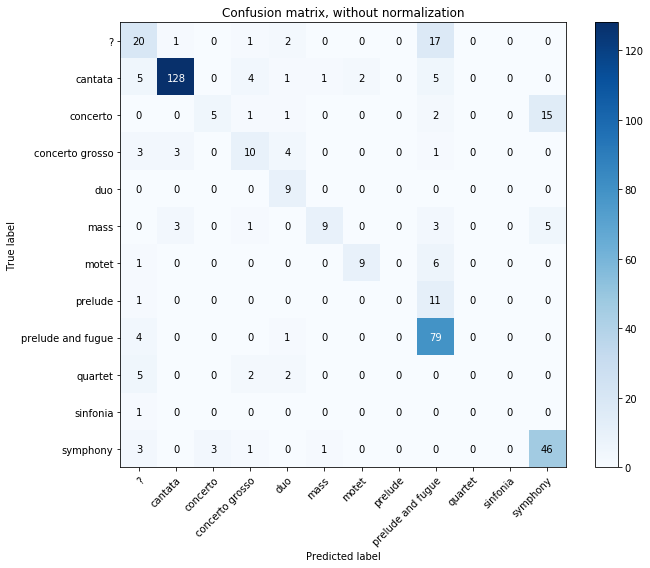

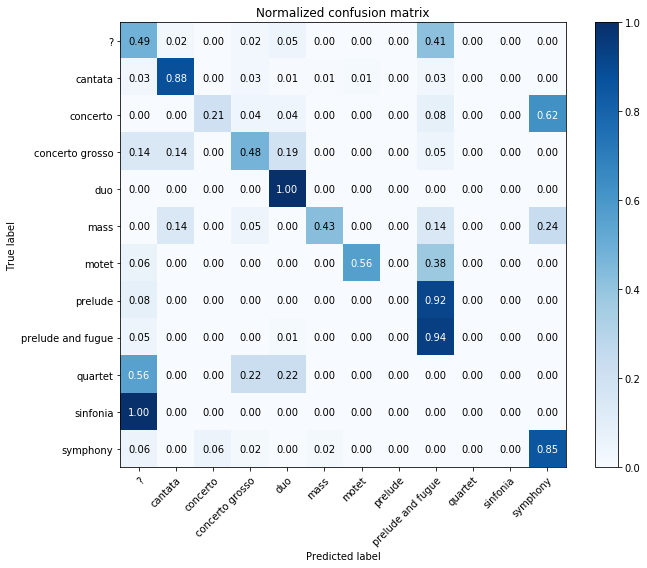

In [21]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=genres,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 2: Composer

In [22]:
composers = np.loadtxt('./dataset/composer.txt', dtype=np.str, delimiter=',')
np.unique(composers)

array(['Bach', 'Beethoven', 'Haydn', 'Mozart'], dtype='<U9')

In [23]:
labels_1hot = onehot_labels(composers)
num_output = labels_1hot.shape[1]

num_output

4

In [24]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [25]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
394/394 [==============================] - 0s 610us/sample - loss: 0.3713 - acc: 0.8648
Epoch 2/100
394/394 [==============================] - 0s 64us/sample - loss: 0.2754 - acc: 0.8909
Epoch 3/100
394/394 [==============================] - 0s 72us/sample - loss: 0.2628 - acc: 0.9016
Epoch 4/100
394/394 [==============================] - 0s 58us/sample - loss: 0.2769 - acc: 0.8940
Epoch 5/100
394/394 [==============================] - 0s 63us/sample - loss: 0.2700 - acc: 0.9061
Epoch 6/100
394/394 [==============================] - 0s 67us/sample - loss: 0.2517 - acc: 0.9036
Epoch 7/100
394/394 [==============================] - 0s 58us/sample - loss: 0.2440 - acc: 0.9061
Epoch 8/100
394/394 [==============================] - 0s 60us/sample - loss: 0.2346 - acc: 0.9086
Epoch 9/100
394/394 [==============================] - 0s 68us/sample - loss: 0.2258 - acc: 0.9048
Epoch 10/100
394/394 [==============================] - 0s 58us/sample - loss: 0.2149 - acc: 0.9086
Epoch 11

394/394 [==============================] - 0s 59us/sample - loss: 0.1060 - acc: 0.9530
Epoch 84/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1137 - acc: 0.9505
Epoch 85/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1013 - acc: 0.9575
Epoch 86/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1072 - acc: 0.9518
Epoch 87/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1112 - acc: 0.9461
Epoch 88/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1056 - acc: 0.9518
Epoch 89/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1084 - acc: 0.9530
Epoch 90/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1002 - acc: 0.9562
Epoch 91/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0991 - acc: 0.9588
Epoch 92/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1046 - acc: 0.9530
Epoch 93/100


394/394 [==============================] - 0s 57us/sample - loss: 0.1466 - acc: 0.9340
Epoch 46/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1341 - acc: 0.9340
Epoch 47/100
394/394 [==============================] - 0s 60us/sample - loss: 0.1398 - acc: 0.9435
Epoch 48/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1395 - acc: 0.9448
Epoch 49/100
394/394 [==============================] - 0s 54us/sample - loss: 0.1529 - acc: 0.9359
Epoch 50/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1307 - acc: 0.9416
Epoch 51/100
394/394 [==============================] - 0s 53us/sample - loss: 0.1278 - acc: 0.9442
Epoch 52/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1366 - acc: 0.9359
Epoch 53/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1375 - acc: 0.9404
Epoch 54/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1242 - acc: 0.9423
Epoch 55/100


394/394 [==============================] - 0s 54us/sample - loss: 0.2336 - acc: 0.9067
Epoch 8/100
394/394 [==============================] - 0s 56us/sample - loss: 0.2091 - acc: 0.9118
Epoch 9/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1969 - acc: 0.9181
Epoch 10/100
394/394 [==============================] - 0s 59us/sample - loss: 0.2141 - acc: 0.9093
Epoch 11/100
394/394 [==============================] - 0s 55us/sample - loss: 0.2092 - acc: 0.9093
Epoch 12/100
394/394 [==============================] - 0s 61us/sample - loss: 0.2072 - acc: 0.9131
Epoch 13/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1767 - acc: 0.9169
Epoch 14/100
394/394 [==============================] - 0s 63us/sample - loss: 0.2063 - acc: 0.9118
Epoch 15/100
394/394 [==============================] - 0s 63us/sample - loss: 0.1705 - acc: 0.9226
Epoch 16/100
394/394 [==============================] - 0s 66us/sample - loss: 0.1655 - acc: 0.9194
Epoch 17/100
39

394/394 [==============================] - 0s 63us/sample - loss: 0.1170 - acc: 0.9473
Epoch 90/100
394/394 [==============================] - 0s 60us/sample - loss: 0.1068 - acc: 0.9473
Epoch 91/100
394/394 [==============================] - 0s 66us/sample - loss: 0.1006 - acc: 0.9530
Epoch 92/100
394/394 [==============================] - 0s 57us/sample - loss: 0.0980 - acc: 0.9543
Epoch 93/100
394/394 [==============================] - 0s 67us/sample - loss: 0.1302 - acc: 0.9442
Epoch 94/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1323 - acc: 0.9385
Epoch 95/100
394/394 [==============================] - 0s 61us/sample - loss: 0.1164 - acc: 0.9429
Epoch 96/100
394/394 [==============================] - 0s 56us/sample - loss: 0.1148 - acc: 0.9454
Epoch 97/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1075 - acc: 0.9575
Epoch 98/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1144 - acc: 0.9499
Epoch 99/100


394/394 [==============================] - 0s 61us/sample - loss: 0.1444 - acc: 0.9346
Epoch 52/100
394/394 [==============================] - 0s 60us/sample - loss: 0.1419 - acc: 0.9378
Epoch 53/100
394/394 [==============================] - 0s 65us/sample - loss: 0.1340 - acc: 0.9391
Epoch 54/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1393 - acc: 0.9410
Epoch 55/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1412 - acc: 0.9372
Epoch 56/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1363 - acc: 0.9359
Epoch 57/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1407 - acc: 0.9423
Epoch 58/100
394/394 [==============================] - 0s 55us/sample - loss: 0.1346 - acc: 0.9365
Epoch 59/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1498 - acc: 0.9334
Epoch 60/100
394/394 [==============================] - 0s 58us/sample - loss: 0.1479 - acc: 0.9372
Epoch 61/100


395/395 [==============================] - 0s 59us/sample - loss: 0.1999 - acc: 0.9000
Epoch 14/100
395/395 [==============================] - 0s 61us/sample - loss: 0.1938 - acc: 0.9076
Epoch 15/100
395/395 [==============================] - 0s 64us/sample - loss: 0.2169 - acc: 0.9051
Epoch 16/100
395/395 [==============================] - 0s 66us/sample - loss: 0.2202 - acc: 0.9025
Epoch 17/100
395/395 [==============================] - 0s 65us/sample - loss: 0.1977 - acc: 0.9095
Epoch 18/100
395/395 [==============================] - 0s 62us/sample - loss: 0.1978 - acc: 0.9127
Epoch 19/100
395/395 [==============================] - 0s 58us/sample - loss: 0.2053 - acc: 0.9127
Epoch 20/100
395/395 [==============================] - 0s 68us/sample - loss: 0.1695 - acc: 0.9184
Epoch 21/100
395/395 [==============================] - 0s 64us/sample - loss: 0.1810 - acc: 0.9171
Epoch 22/100
395/395 [==============================] - 0s 65us/sample - loss: 0.1720 - acc: 0.9203
Epoch 23/100


395/395 [==============================] - 0s 64us/sample - loss: 0.1287 - acc: 0.9405
Epoch 96/100
395/395 [==============================] - 0s 60us/sample - loss: 0.1241 - acc: 0.9462
Epoch 97/100
395/395 [==============================] - 0s 63us/sample - loss: 0.1222 - acc: 0.9462
Epoch 98/100
395/395 [==============================] - 0s 57us/sample - loss: 0.1211 - acc: 0.9494
Epoch 99/100
395/395 [==============================] - 0s 61us/sample - loss: 0.1320 - acc: 0.9475
Epoch 100/100
43/43 [==============================] - 0s 4ms/sample - loss: 0.0411 - acc: 0.9767
Epoch 1/100
395/395 [==============================] - 0s 790us/sample - loss: 0.4092 - acc: 0.8203
Epoch 2/100
395/395 [==============================] - 0s 65us/sample - loss: 0.3213 - acc: 0.8741
Epoch 3/100
395/395 [==============================] - 0s 70us/sample - loss: 0.3012 - acc: 0.8867
Epoch 4/100
395/395 [==============================] - 0s 62us/sample - loss: 0.2990 - acc: 0.8867
Epoch 5/100
395/39

array([0.88, 0.86, 0.91, 0.88, 0.87, 0.95, 0.95, 0.9 , 0.98, 1.  ])

In [26]:
score['composer'] = np.mean(scores)
np.mean(scores)

0.9186971426010132

In [27]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

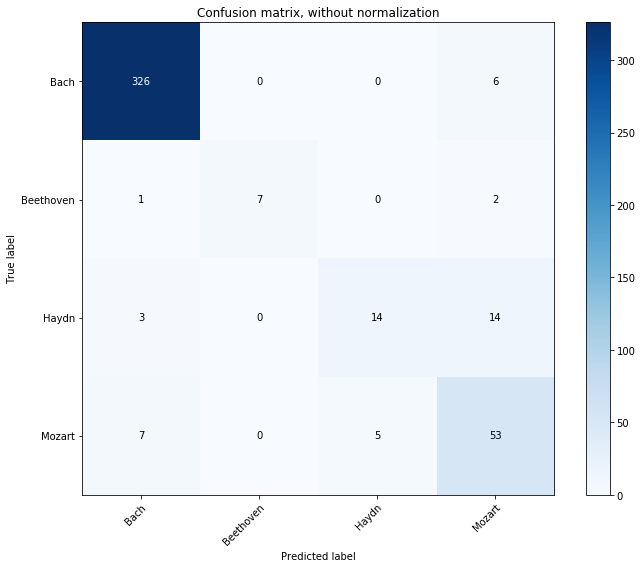

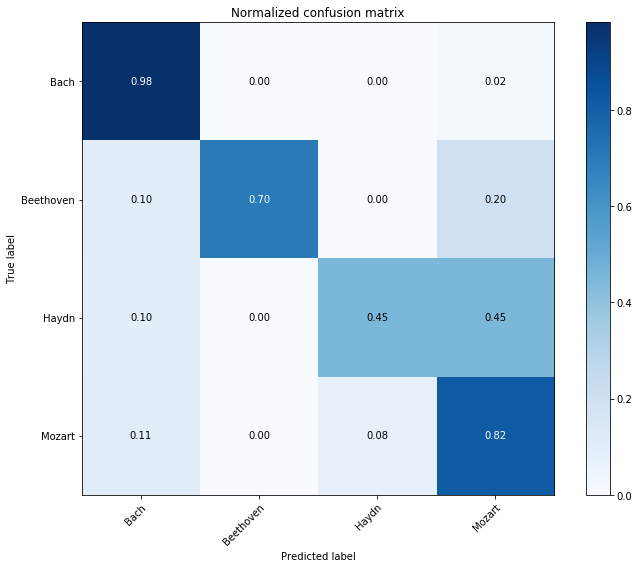

In [28]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=composers,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=composers, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 3: Key

In [59]:
uris = np.loadtxt('./dataset/uri_doremus.txt', dtype=np.str, delimiter=',')
uris

array(['http://data.doremus.org/expression/ce2be9cf-17c7-33fa-8e98-93b969795b74',
       'http://data.doremus.org/expression/a986bec7-90a3-305d-977e-077509a130ba',
       'http://data.doremus.org/expression/7ea8ced2-9033-342c-8160-ab8e2db8b18a',
       'http://data.doremus.org/expression/a986bec7-90a3-305d-977e-077509a130ba',
       'http://data.doremus.org/expression/b9c0feed-8c3f-3bfc-8919-0f900bdc34ba',
       'http://data.doremus.org/expression/19a865ff-9c37-3170-b3be-79d2fe2fcd55',
       'http://data.doremus.org/expression/7ea8ced2-9033-342c-8160-ab8e2db8b18a',
       'http://data.doremus.org/expression/ce2be9cf-17c7-33fa-8e98-93b969795b74',
       'http://data.doremus.org/expression/16190e8e-d78c-3b91-a327-5a2eed3b9f67',
       'http://data.doremus.org/expression/7fd88d80-8f05-33b1-a4cc-83c903ff559e',
       'http://data.doremus.org/expression/56180c45-c620-330b-a474-e4a6603b42a8',
       'http://data.doremus.org/expression/7ea8ced2-9033-342c-8160-ab8e2db8b18a',
       'http://d

In [29]:
key = np.loadtxt('./dataset/key.txt', dtype=np.str, delimiter=',')
np.unique(key)

array(['?', 'A Major', 'A Minor', 'A flat Major', 'B Major', 'B Minor',
       'B flat Major', 'B flat Minor', 'C Major', 'C Minor',
       'C sharp Major', 'C sharp Minor', 'D Major', 'D Minor',
       'D sharp Minor', 'E Major', 'E Minor', 'E flat Major',
       'E flat Minor', 'F Major', 'F Minor', 'F sharp Major',
       'F sharp Minor', 'G Major', 'G Minor', 'G sharp Minor'],
      dtype='<U13')

In [30]:
labels_1hot = onehot_labels(key)
num_output = labels_1hot.shape[1]
num_output

26

In [31]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [32]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
394/394 [==============================] - 0s 886us/sample - loss: 0.2986 - acc: 0.8854
Epoch 2/100
394/394 [==============================] - 0s 68us/sample - loss: 0.1486 - acc: 0.9598
Epoch 3/100
394/394 [==============================] - 0s 83us/sample - loss: 0.1269 - acc: 0.9621
Epoch 4/100
394/394 [==============================] - 0s 71us/sample - loss: 0.1246 - acc: 0.9621
Epoch 5/100
394/394 [==============================] - 0s 69us/sample - loss: 0.1233 - acc: 0.9603
Epoch 6/100
394/394 [==============================] - 0s 69us/sample - loss: 0.1223 - acc: 0.9616
Epoch 7/100
394/394 [==============================] - 0s 69us/sample - loss: 0.1220 - acc: 0.9642
Epoch 8/100
394/394 [==============================] - 0s 71us/sample - loss: 0.1217 - acc: 0.9632
Epoch 9/100
394/394 [==============================] - 0s 68us/sample - loss: 0.1212 - acc: 0.9631
Epoch 10/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1205 - acc: 0.9638
Epoch 11

394/394 [==============================] - 0s 69us/sample - loss: 0.0897 - acc: 0.9739
Epoch 84/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0903 - acc: 0.9739
Epoch 85/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0883 - acc: 0.9734
Epoch 86/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0878 - acc: 0.9741
Epoch 87/100
394/394 [==============================] - 0s 74us/sample - loss: 0.0903 - acc: 0.9732
Epoch 88/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0921 - acc: 0.9723
Epoch 89/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0898 - acc: 0.9730
Epoch 90/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0866 - acc: 0.9736
Epoch 91/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0845 - acc: 0.9743
Epoch 92/100
394/394 [==============================] - 0s 64us/sample - loss: 0.0841 - acc: 0.9745
Epoch 93/100


394/394 [==============================] - 0s 60us/sample - loss: 0.1008 - acc: 0.9708
Epoch 46/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1034 - acc: 0.9698
Epoch 47/100
394/394 [==============================] - 0s 75us/sample - loss: 0.1023 - acc: 0.9702
Epoch 48/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0995 - acc: 0.9726
Epoch 49/100
394/394 [==============================] - 0s 65us/sample - loss: 0.1020 - acc: 0.9714
Epoch 50/100
394/394 [==============================] - 0s 64us/sample - loss: 0.0977 - acc: 0.9724
Epoch 51/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0969 - acc: 0.9733
Epoch 52/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0950 - acc: 0.9734
Epoch 53/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0948 - acc: 0.9738
Epoch 54/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0976 - acc: 0.9714
Epoch 55/100


394/394 [==============================] - 0s 75us/sample - loss: 0.1218 - acc: 0.9623
Epoch 8/100
394/394 [==============================] - 0s 67us/sample - loss: 0.1211 - acc: 0.9625
Epoch 9/100
394/394 [==============================] - 0s 76us/sample - loss: 0.1213 - acc: 0.9615
Epoch 10/100
394/394 [==============================] - 0s 68us/sample - loss: 0.1205 - acc: 0.9625
Epoch 11/100
394/394 [==============================] - 0s 65us/sample - loss: 0.1197 - acc: 0.9617
Epoch 12/100
394/394 [==============================] - 0s 65us/sample - loss: 0.1199 - acc: 0.9630
Epoch 13/100
394/394 [==============================] - 0s 67us/sample - loss: 0.1183 - acc: 0.9620
Epoch 14/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1172 - acc: 0.9613
Epoch 15/100
394/394 [==============================] - 0s 61us/sample - loss: 0.1172 - acc: 0.9616
Epoch 16/100
394/394 [==============================] - 0s 66us/sample - loss: 0.1166 - acc: 0.9620
Epoch 17/100
39

394/394 [==============================] - 0s 69us/sample - loss: 0.0857 - acc: 0.9735
Epoch 90/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0846 - acc: 0.9743
Epoch 91/100
394/394 [==============================] - 0s 74us/sample - loss: 0.0818 - acc: 0.9756
Epoch 92/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0821 - acc: 0.9749
Epoch 93/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0819 - acc: 0.9749
Epoch 94/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0823 - acc: 0.9746
Epoch 95/100
394/394 [==============================] - 0s 64us/sample - loss: 0.0844 - acc: 0.9741
Epoch 96/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0831 - acc: 0.9747
Epoch 97/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0803 - acc: 0.9754
Epoch 98/100
394/394 [==============================] - 0s 64us/sample - loss: 0.0804 - acc: 0.9753
Epoch 99/100


394/394 [==============================] - 0s 73us/sample - loss: 0.0906 - acc: 0.9745
Epoch 52/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0913 - acc: 0.9741
Epoch 53/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0894 - acc: 0.9750
Epoch 54/100
394/394 [==============================] - 0s 70us/sample - loss: 0.0892 - acc: 0.9743
Epoch 55/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0891 - acc: 0.9741
Epoch 56/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0881 - acc: 0.9748
Epoch 57/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0894 - acc: 0.9729
Epoch 58/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0886 - acc: 0.9740
Epoch 59/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0867 - acc: 0.9746
Epoch 60/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0879 - acc: 0.9740
Epoch 61/100


395/395 [==============================] - 0s 65us/sample - loss: 0.1117 - acc: 0.9639
Epoch 14/100
395/395 [==============================] - 0s 69us/sample - loss: 0.1107 - acc: 0.9640
Epoch 15/100
395/395 [==============================] - 0s 69us/sample - loss: 0.1093 - acc: 0.9639
Epoch 16/100
395/395 [==============================] - 0s 63us/sample - loss: 0.1093 - acc: 0.9632
Epoch 17/100
395/395 [==============================] - 0s 61us/sample - loss: 0.1092 - acc: 0.9638
Epoch 18/100
395/395 [==============================] - 0s 61us/sample - loss: 0.1071 - acc: 0.9645
Epoch 19/100
395/395 [==============================] - 0s 65us/sample - loss: 0.1073 - acc: 0.9645
Epoch 20/100
395/395 [==============================] - 0s 61us/sample - loss: 0.1059 - acc: 0.9651
Epoch 21/100
395/395 [==============================] - 0s 67us/sample - loss: 0.1040 - acc: 0.9674
Epoch 22/100
395/395 [==============================] - 0s 70us/sample - loss: 0.1055 - acc: 0.9662
Epoch 23/100


395/395 [==============================] - 0s 67us/sample - loss: 0.0914 - acc: 0.9722
Epoch 96/100
395/395 [==============================] - 0s 66us/sample - loss: 0.0869 - acc: 0.9743
Epoch 97/100
395/395 [==============================] - 0s 65us/sample - loss: 0.0852 - acc: 0.9731
Epoch 98/100
395/395 [==============================] - 0s 62us/sample - loss: 0.0807 - acc: 0.9752
Epoch 99/100
395/395 [==============================] - 0s 64us/sample - loss: 0.0783 - acc: 0.9762
Epoch 100/100
43/43 [==============================] - 0s 6ms/sample - loss: 0.1626 - acc: 0.9589
Epoch 1/100
395/395 [==============================] - 0s 977us/sample - loss: 0.2827 - acc: 0.9183
Epoch 2/100
395/395 [==============================] - 0s 70us/sample - loss: 0.1399 - acc: 0.9612
Epoch 3/100
395/395 [==============================] - 0s 68us/sample - loss: 0.1201 - acc: 0.9610
Epoch 4/100
395/395 [==============================] - 0s 64us/sample - loss: 0.1178 - acc: 0.9597
Epoch 5/100
395/39

array([0.98, 0.98, 0.98, 0.98, 0.97, 0.98, 0.97, 0.97, 0.96, 0.96])

In [33]:
score['key'] = np.mean(scores)

In [34]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

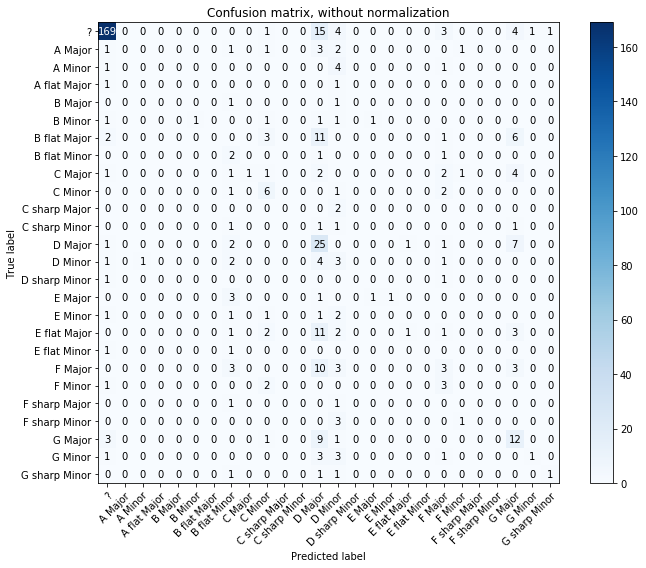

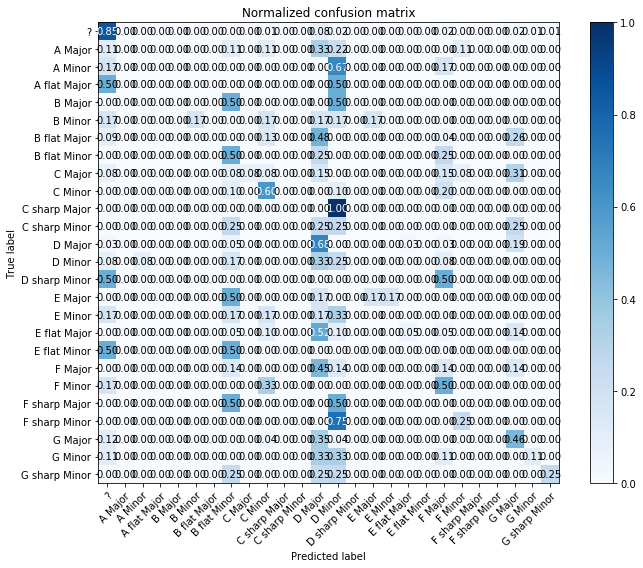

In [35]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=key,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=key, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 4: Movement

In [36]:
mvt = np.loadtxt('./dataset/mvt.txt', dtype=np.str, delimiter=',')
np.unique(mvt)

array(['?', 'Adagio', 'Adagio-Allegro', 'Adagio-Allegro con spirito',
       'Adagio-Presto', 'Adagio-Vivace assai', 'Affettuoso', 'Allegretto',
       'Allegro', 'Allegro assai', 'Allegro con brio',
       'Allegro con spirito', 'Allegro molto', 'Allegro vivace',
       'Andante', 'Andante cantabile', 'Andante con moto',
       'Andante grazioso', 'Andante un poco Allegretto', 'Aria', 'Choral',
       'Choral und Aria', 'Chorale', 'Chorus', 'Coro', 'Credo',
       'Crucifixus', 'Dona nobis pacem', 'Duetto', 'Et incarnatus est',
       'Et resurrexit', 'Finale', 'Fugue', 'Gloria', 'Gratias agimus',
       'Kyrie', 'Largo-Allegro vivace', 'Menuet and Trio', 'Menuetto',
       'Menuetto and Trio', 'Molto Allegro', 'Osanna',
       'Patrem omnipotentem', 'Polacca', 'Prelude', 'Presto',
       'Recitative', 'Recitativo', 'Recitativo a tempo', 'Romanze',
       'Rondeau', 'Rondo', 'Sanctus', 'Scherzo', 'Sinfonia', 'Spiritoso',
       'Tempo di Menuetto', 'Tempo di Minuetto', 'Trio', 'Un poc

In [37]:
labels_1hot = onehot_labels(mvt)
num_output = labels_1hot.shape[1]
num_output

62

In [38]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [39]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
394/394 [==============================] - 0s 1ms/sample - loss: 0.2739 - acc: 0.9189
Epoch 2/100
394/394 [==============================] - 0s 76us/sample - loss: 0.0990 - acc: 0.9820
Epoch 3/100
394/394 [==============================] - 0s 78us/sample - loss: 0.0722 - acc: 0.9839
Epoch 4/100
394/394 [==============================] - 0s 84us/sample - loss: 0.0662 - acc: 0.9839
Epoch 5/100
394/394 [==============================] - 0s 84us/sample - loss: 0.0658 - acc: 0.9839
Epoch 6/100
394/394 [==============================] - 0s 78us/sample - loss: 0.0649 - acc: 0.9839
Epoch 7/100
394/394 [==============================] - 0s 82us/sample - loss: 0.0654 - acc: 0.9839
Epoch 8/100
394/394 [==============================] - 0s 80us/sample - loss: 0.0653 - acc: 0.9839
Epoch 9/100
394/394 [==============================] - 0s 79us/sample - loss: 0.0649 - acc: 0.9839
Epoch 10/100
394/394 [==============================] - 0s 79us/sample - loss: 0.0648 - acc: 0.9839
Epoch 11/1

394/394 [==============================] - 0s 72us/sample - loss: 0.0432 - acc: 0.9851
Epoch 84/100
394/394 [==============================] - 0s 74us/sample - loss: 0.0437 - acc: 0.9837
Epoch 85/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0434 - acc: 0.9841
Epoch 86/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0427 - acc: 0.9842
Epoch 87/100
394/394 [==============================] - 0s 70us/sample - loss: 0.0427 - acc: 0.9841
Epoch 88/100
394/394 [==============================] - 0s 73us/sample - loss: 0.0416 - acc: 0.9845
Epoch 89/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0420 - acc: 0.9851
Epoch 90/100
394/394 [==============================] - 0s 72us/sample - loss: 0.0421 - acc: 0.9843
Epoch 91/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0427 - acc: 0.9840
Epoch 92/100
394/394 [==============================] - 0s 70us/sample - loss: 0.0419 - acc: 0.9846
Epoch 93/100


394/394 [==============================] - 0s 75us/sample - loss: 0.0518 - acc: 0.9842
Epoch 46/100
394/394 [==============================] - 0s 78us/sample - loss: 0.0517 - acc: 0.9838
Epoch 47/100
394/394 [==============================] - 0s 78us/sample - loss: 0.0517 - acc: 0.9843
Epoch 48/100
394/394 [==============================] - 0s 80us/sample - loss: 0.0515 - acc: 0.9840
Epoch 49/100
394/394 [==============================] - 0s 76us/sample - loss: 0.0506 - acc: 0.9842
Epoch 50/100
394/394 [==============================] - 0s 76us/sample - loss: 0.0507 - acc: 0.9840
Epoch 51/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0510 - acc: 0.9841
Epoch 52/100
394/394 [==============================] - 0s 77us/sample - loss: 0.0503 - acc: 0.9841
Epoch 53/100
394/394 [==============================] - 0s 75us/sample - loss: 0.0497 - acc: 0.9840
Epoch 54/100
394/394 [==============================] - 0s 76us/sample - loss: 0.0508 - acc: 0.9841
Epoch 55/100


394/394 [==============================] - 0s 74us/sample - loss: 0.0667 - acc: 0.9839
Epoch 8/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0666 - acc: 0.9839
Epoch 9/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0665 - acc: 0.9839
Epoch 10/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0663 - acc: 0.9839
Epoch 11/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0662 - acc: 0.9839
Epoch 12/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0657 - acc: 0.9839
Epoch 13/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0656 - acc: 0.9839
Epoch 14/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0650 - acc: 0.9839
Epoch 15/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0645 - acc: 0.9839
Epoch 16/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0641 - acc: 0.9839
Epoch 17/100
39

394/394 [==============================] - 0s 67us/sample - loss: 0.0411 - acc: 0.9848
Epoch 90/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0409 - acc: 0.9849
Epoch 91/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0417 - acc: 0.9847
Epoch 92/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0411 - acc: 0.9847
Epoch 93/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0408 - acc: 0.9847
Epoch 94/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0408 - acc: 0.9851
Epoch 95/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0403 - acc: 0.9848
Epoch 96/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0399 - acc: 0.9857
Epoch 97/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0401 - acc: 0.9849
Epoch 98/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0397 - acc: 0.9851
Epoch 99/100


394/394 [==============================] - 0s 67us/sample - loss: 0.0506 - acc: 0.9839
Epoch 52/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0509 - acc: 0.9843
Epoch 53/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0496 - acc: 0.9844
Epoch 54/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0495 - acc: 0.9843
Epoch 55/100
394/394 [==============================] - 0s 70us/sample - loss: 0.0493 - acc: 0.9843
Epoch 56/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0493 - acc: 0.9842
Epoch 57/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0490 - acc: 0.9842
Epoch 58/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0487 - acc: 0.9845
Epoch 59/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0493 - acc: 0.9842
Epoch 60/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0478 - acc: 0.9846
Epoch 61/100


395/395 [==============================] - 0s 70us/sample - loss: 0.0655 - acc: 0.9839
Epoch 14/100
395/395 [==============================] - 0s 72us/sample - loss: 0.0648 - acc: 0.9839
Epoch 15/100
395/395 [==============================] - 0s 67us/sample - loss: 0.0648 - acc: 0.9839
Epoch 16/100
395/395 [==============================] - 0s 68us/sample - loss: 0.0644 - acc: 0.9839
Epoch 17/100
395/395 [==============================] - 0s 67us/sample - loss: 0.0637 - acc: 0.9839
Epoch 18/100
395/395 [==============================] - 0s 76us/sample - loss: 0.0635 - acc: 0.9839
Epoch 19/100
395/395 [==============================] - 0s 74us/sample - loss: 0.0630 - acc: 0.9839
Epoch 20/100
395/395 [==============================] - 0s 69us/sample - loss: 0.0627 - acc: 0.9839
Epoch 21/100
395/395 [==============================] - 0s 71us/sample - loss: 0.0623 - acc: 0.9839
Epoch 22/100
395/395 [==============================] - 0s 68us/sample - loss: 0.0620 - acc: 0.9838
Epoch 23/100


395/395 [==============================] - 0s 76us/sample - loss: 0.0403 - acc: 0.9852
Epoch 96/100
395/395 [==============================] - 0s 81us/sample - loss: 0.0407 - acc: 0.9851
Epoch 97/100
395/395 [==============================] - 0s 74us/sample - loss: 0.0395 - acc: 0.9858
Epoch 98/100
395/395 [==============================] - 0s 78us/sample - loss: 0.0393 - acc: 0.9855
Epoch 99/100
395/395 [==============================] - 0s 83us/sample - loss: 0.0394 - acc: 0.9848
Epoch 100/100
43/43 [==============================] - 0s 8ms/sample - loss: 0.0347 - acc: 0.9839
Epoch 1/100
395/395 [==============================] - 0s 1ms/sample - loss: 0.2637 - acc: 0.9271
Epoch 2/100
395/395 [==============================] - 0s 72us/sample - loss: 0.1044 - acc: 0.9827
Epoch 3/100
395/395 [==============================] - 0s 73us/sample - loss: 0.0741 - acc: 0.9839
Epoch 4/100
395/395 [==============================] - 0s 72us/sample - loss: 0.0692 - acc: 0.9839
Epoch 5/100
395/395 

array([0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98])

In [40]:
score['mvt'] = np.mean(scores)

In [14]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

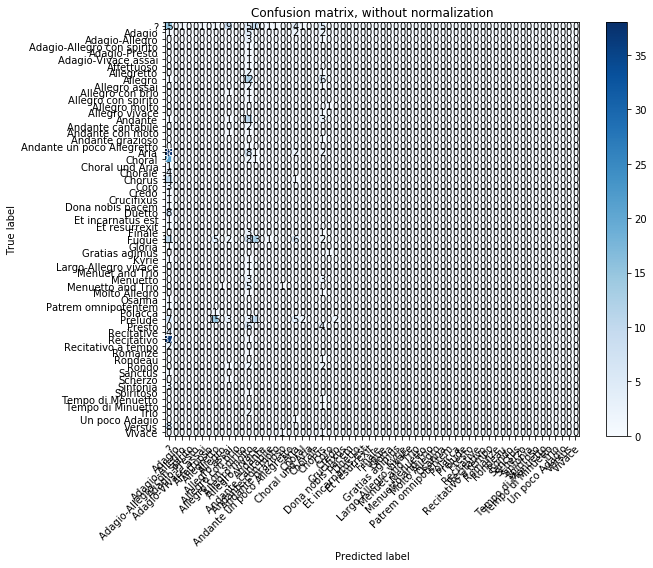

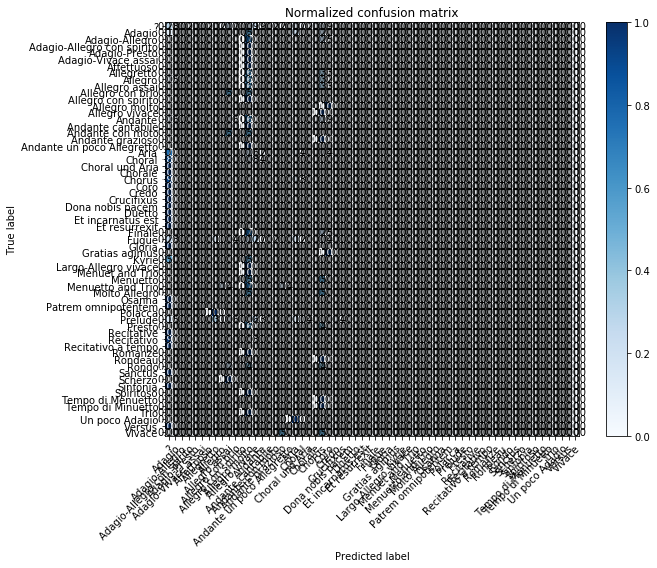

In [41]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=mvt,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=mvt, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 5: Instrument

In [42]:
instrument = np.loadtxt('./dataset/instrument.txt', dtype=np.str, delimiter=',')
np.unique(instrument)

array(['?',
       'Bassoon+Clarinet+Double bassoon+Flute+Horn+Kettledrum+Oboe+Piccolo flute+Trombone+Trumpet+cordes (instrument)',
       'Pianoforte+orchestra', 'Viola+Violin+Violoncello',
       'bassoon+continuo+horn+oboe+string orchestra+violin',
       'cello+continuo+viola+violin', 'cello+viola+violin',
       'clarinet+orchestra - other',
       'continuo+flute+harpsichord+string orchestra+violin',
       'continuo+oboe+recorder+string orchestra+trumpet+violin',
       'continuo+orchestra+voice',
       'continuo+recorder+string orchestra+violin',
       'continuo+string orchestra+violin',
       'double bass+harpsichord+viol+viola', 'full orchestra',
       'full orchestra+violin', 'full orchestra+voice', 'harpsichord',
       'horn', 'keyboard', 'mixed choir', 'mixed choir+orchestra - other',
       'mixed choir+organ', 'orchestra - other',
       'orchestra - other+piano', 'viola+violin', 'voice'], dtype='<U109')

In [43]:
labels_1hot = onehot_labels(instrument)
num_output = labels_1hot.shape[1]
num_output

27

In [44]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [45]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
394/394 [==============================] - 0s 1ms/sample - loss: 0.2958 - acc: 0.9193
Epoch 2/100
394/394 [==============================] - 0s 61us/sample - loss: 0.1404 - acc: 0.9607
Epoch 3/100
394/394 [==============================] - 0s 68us/sample - loss: 0.1158 - acc: 0.9630
Epoch 4/100
394/394 [==============================] - 0s 57us/sample - loss: 0.1142 - acc: 0.9639
Epoch 5/100
394/394 [==============================] - 0s 63us/sample - loss: 0.1110 - acc: 0.9636
Epoch 6/100
394/394 [==============================] - 0s 60us/sample - loss: 0.1067 - acc: 0.9644
Epoch 7/100
394/394 [==============================] - 0s 59us/sample - loss: 0.1048 - acc: 0.9631
Epoch 8/100
394/394 [==============================] - 0s 64us/sample - loss: 0.1016 - acc: 0.9656
Epoch 9/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0993 - acc: 0.9658
Epoch 10/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0994 - acc: 0.9654
Epoch 11/1

394/394 [==============================] - 0s 59us/sample - loss: 0.0508 - acc: 0.9813
Epoch 84/100
394/394 [==============================] - 0s 64us/sample - loss: 0.0509 - acc: 0.9814
Epoch 85/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0487 - acc: 0.9818
Epoch 86/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0483 - acc: 0.9811
Epoch 87/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0499 - acc: 0.9818
Epoch 88/100
394/394 [==============================] - 0s 59us/sample - loss: 0.0479 - acc: 0.9819
Epoch 89/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0547 - acc: 0.9792
Epoch 90/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0504 - acc: 0.9808
Epoch 91/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0496 - acc: 0.9815
Epoch 92/100
394/394 [==============================] - 0s 60us/sample - loss: 0.0490 - acc: 0.9807
Epoch 93/100


394/394 [==============================] - 0s 65us/sample - loss: 0.0624 - acc: 0.9765
Epoch 46/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0610 - acc: 0.9771
Epoch 47/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0613 - acc: 0.9782
Epoch 48/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0578 - acc: 0.9788
Epoch 49/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0578 - acc: 0.9788
Epoch 50/100
394/394 [==============================] - 0s 62us/sample - loss: 0.0599 - acc: 0.9790
Epoch 51/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0576 - acc: 0.9788
Epoch 52/100
394/394 [==============================] - 0s 63us/sample - loss: 0.0578 - acc: 0.9794
Epoch 53/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0582 - acc: 0.9797
Epoch 54/100
394/394 [==============================] - 0s 65us/sample - loss: 0.0557 - acc: 0.9799
Epoch 55/100


394/394 [==============================] - 0s 66us/sample - loss: 0.1098 - acc: 0.9625
Epoch 8/100
394/394 [==============================] - 0s 68us/sample - loss: 0.1079 - acc: 0.9633
Epoch 9/100
394/394 [==============================] - 0s 67us/sample - loss: 0.1069 - acc: 0.9648
Epoch 10/100
394/394 [==============================] - 0s 66us/sample - loss: 0.1064 - acc: 0.9632
Epoch 11/100
394/394 [==============================] - 0s 71us/sample - loss: 0.1053 - acc: 0.9635
Epoch 12/100
394/394 [==============================] - 0s 66us/sample - loss: 0.1040 - acc: 0.9638
Epoch 13/100
394/394 [==============================] - 0s 70us/sample - loss: 0.1023 - acc: 0.9644
Epoch 14/100
394/394 [==============================] - 0s 71us/sample - loss: 0.1021 - acc: 0.9647
Epoch 15/100
394/394 [==============================] - 0s 69us/sample - loss: 0.1001 - acc: 0.9674
Epoch 16/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0974 - acc: 0.9684
Epoch 17/100
39

394/394 [==============================] - 0s 66us/sample - loss: 0.0510 - acc: 0.9806
Epoch 90/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0507 - acc: 0.9807
Epoch 91/100
394/394 [==============================] - 0s 66us/sample - loss: 0.0520 - acc: 0.9796
Epoch 92/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0502 - acc: 0.9806
Epoch 93/100
394/394 [==============================] - 0s 71us/sample - loss: 0.0524 - acc: 0.9791
Epoch 94/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0505 - acc: 0.9805
Epoch 95/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0504 - acc: 0.9806
Epoch 96/100
394/394 [==============================] - 0s 68us/sample - loss: 0.0523 - acc: 0.9797
Epoch 97/100
394/394 [==============================] - 0s 69us/sample - loss: 0.0496 - acc: 0.9806
Epoch 98/100
394/394 [==============================] - 0s 67us/sample - loss: 0.0507 - acc: 0.9804
Epoch 99/100


394/394 [==============================] - 0s 85us/sample - loss: 0.0595 - acc: 0.9778
Epoch 52/100
394/394 [==============================] - 0s 85us/sample - loss: 0.0598 - acc: 0.9784
Epoch 53/100
394/394 [==============================] - 0s 86us/sample - loss: 0.0612 - acc: 0.9773
Epoch 54/100
394/394 [==============================] - 0s 80us/sample - loss: 0.0624 - acc: 0.9766
Epoch 55/100
394/394 [==============================] - 0s 77us/sample - loss: 0.0640 - acc: 0.9771
Epoch 56/100
394/394 [==============================] - 0s 79us/sample - loss: 0.0631 - acc: 0.9773
Epoch 57/100
394/394 [==============================] - 0s 81us/sample - loss: 0.0609 - acc: 0.9787
Epoch 58/100
394/394 [==============================] - 0s 81us/sample - loss: 0.0587 - acc: 0.9783
Epoch 59/100
394/394 [==============================] - 0s 81us/sample - loss: 0.0593 - acc: 0.9782
Epoch 60/100
394/394 [==============================] - 0s 80us/sample - loss: 0.0585 - acc: 0.9782
Epoch 61/100


395/395 [==============================] - 0s 68us/sample - loss: 0.1071 - acc: 0.9664
Epoch 14/100
395/395 [==============================] - 0s 68us/sample - loss: 0.1061 - acc: 0.9648
Epoch 15/100
395/395 [==============================] - 0s 74us/sample - loss: 0.1051 - acc: 0.9648
Epoch 16/100
395/395 [==============================] - 0s 70us/sample - loss: 0.1036 - acc: 0.9656
Epoch 17/100
395/395 [==============================] - 0s 72us/sample - loss: 0.1057 - acc: 0.9632
Epoch 18/100
395/395 [==============================] - 0s 72us/sample - loss: 0.1032 - acc: 0.9657
Epoch 19/100
395/395 [==============================] - 0s 72us/sample - loss: 0.1014 - acc: 0.9630
Epoch 20/100
395/395 [==============================] - 0s 79us/sample - loss: 0.1005 - acc: 0.9651
Epoch 21/100
395/395 [==============================] - 0s 84us/sample - loss: 0.0986 - acc: 0.9668
Epoch 22/100
395/395 [==============================] - 0s 86us/sample - loss: 0.0972 - acc: 0.9662
Epoch 23/100


395/395 [==============================] - 0s 75us/sample - loss: 0.0514 - acc: 0.9799
Epoch 96/100
395/395 [==============================] - 0s 75us/sample - loss: 0.0496 - acc: 0.9803
Epoch 97/100
395/395 [==============================] - 0s 77us/sample - loss: 0.0504 - acc: 0.9803
Epoch 98/100
395/395 [==============================] - 0s 77us/sample - loss: 0.0573 - acc: 0.9788
Epoch 99/100
395/395 [==============================] - 0s 76us/sample - loss: 0.0530 - acc: 0.9809
Epoch 100/100
43/43 [==============================] - 0s 10ms/sample - loss: 0.0330 - acc: 0.9914
Epoch 1/100
395/395 [==============================] - 1s 1ms/sample - loss: 0.2808 - acc: 0.9252
Epoch 2/100
395/395 [==============================] - 0s 74us/sample - loss: 0.1453 - acc: 0.9630
Epoch 3/100
395/395 [==============================] - 0s 76us/sample - loss: 0.1238 - acc: 0.9630
Epoch 4/100
395/395 [==============================] - 0s 70us/sample - loss: 0.1196 - acc: 0.9630
Epoch 5/100
395/395

array([0.95, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.99, 0.97])

In [46]:
score['instrument'] = np.mean(scores)

In [50]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

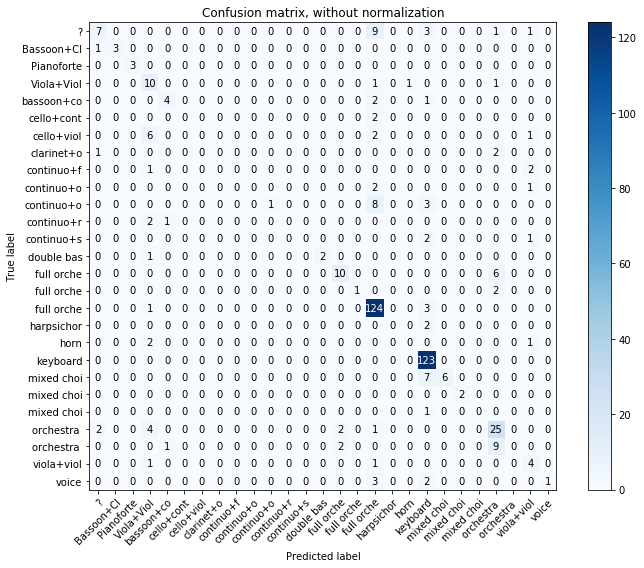

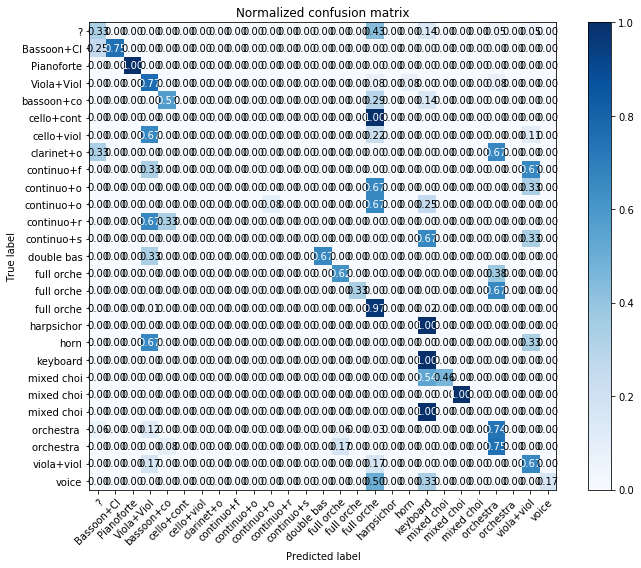

In [55]:
np.set_printoptions(precision=2)
plot_confusion_matrix(labels_1hot, predicted, classes=instrument,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=instrument, normalize=True,
                      title='Normalized confusion matrix')

In [49]:
score

{'composer': 0.9186971426010132,
 'genre': 0.9389182448387146,
 'instrument': 0.9733067095279694,
 'key': 0.9722861230373383,
 'mvt': 0.983503544330597}